In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from tensorflow import keras
from glob import glob
import matplotlib.pyplot as plt

In [2]:
Image_size=256
Batch_size=64
Channels=3
epochs=35

In [3]:
dataset=keras.preprocessing.image_dataset_from_directory(
    "./Food Classification/",
    shuffle=True,
    color_mode='rgb',
    image_size=(Image_size,Image_size),
    batch_size=Batch_size
)

Found 6269 files belonging to 20 classes.


In [4]:
classnames=dataset.class_names

In [5]:
classnames

['burger',
 'butter_naan',
 'chai',
 'chapati',
 'chole_bhature',
 'dal_makhani',
 'dhokla',
 'fried_rice',
 'idli',
 'jalebi',
 'kaathi_rolls',
 'kadai_paneer',
 'kulfi',
 'masala_dosa',
 'momos',
 'paani_puri',
 'pakode',
 'pav_bhaji',
 'pizza',
 'samosa']

In [6]:
len(classnames)

20

In [7]:
len(dataset)

98

In [8]:
98*Batch_size#every element is a batch of 32

6272

In [9]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch[0])

tf.Tensor(
[[[202.0791   211.0791   220.0791  ]
  [200.75     209.75     218.75    ]
  [199.0791   208.0791   217.0791  ]
  ...
  [ 95.80371   71.80371   45.80371 ]
  [ 95.012695  71.012695  45.012695]
  [ 89.35449   65.35449   39.354492]]

 [[203.91113  212.91113  221.91113 ]
  [202.64844  211.64844  220.64844 ]
  [200.91113  209.91113  218.91113 ]
  ...
  [ 98.66113   74.66113   48.661133]
  [ 94.737305  70.737305  44.737305]
  [ 86.60156   62.601562  36.601562]]

 [[210.16016  219.16016  228.16016 ]
  [208.66016  217.66016  226.66016 ]
  [207.16016  216.16016  225.16016 ]
  ...
  [ 99.75      75.75      49.75    ]
  [ 94.        70.        44.      ]
  [ 85.25      61.25      35.25    ]]

 ...

 [[104.74609   97.74609   89.74609 ]
  [104.33203   97.33203   89.33203 ]
  [102.268555  95.268555  87.268555]
  ...
  [ 97.        81.        56.      ]
  [ 97.        81.        56.      ]
  [ 97.        81.        56.      ]]

 [[101.10156   94.10156   86.10156 ]
  [103.228516  96.228516  

In [10]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch[0].shape, label_batch)

(256, 256, 3) tf.Tensor(
[14  7 17  4 15  5  5 11 12 17  8  2  3 12 17 17  8  4  5 14 14  0 13 12
  5  7 18  8  4  2 13  1 17 11 14 14  3 10  6  7  1  2 14 13  9  4 18 14
  9  1 12 10 13  6  5  4  9  7  5 12 18 16  4 18], shape=(64,), dtype=int32)


In [11]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch.shape, len(label_batch))

(64, 256, 256, 3) 64


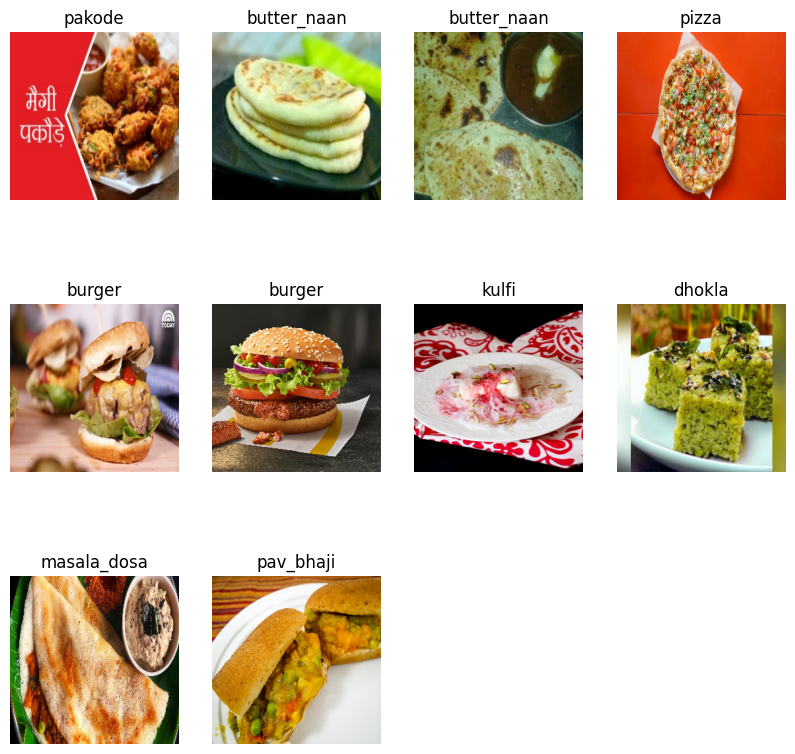

In [12]:
plt.figure(figsize=(10,10))
#for 1st take of batch there are 32 images i want to see the 10 images of 1st batch
for image_batch, labels_batch in dataset.take(1):
    for i in range(10):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))#accepts 3d input
        plt.title(classnames[labels_batch[i]])
        plt.axis("off")

In [13]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [14]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [15]:
len(train_ds)

78

In [16]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [17]:
resize_and_rescale = tf.keras.Sequential([
  keras.layers.experimental.preprocessing.Resizing(Image_size, Image_size),
  keras.layers.experimental.preprocessing.Rescaling(1./255),
])

In [18]:
data_augmentation = tf.keras.Sequential([
  keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

In [19]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [20]:
len(train_ds)

78

In [21]:
vgg16 = VGG16(input_shape=(Image_size,Image_size,3), weights='imagenet', include_top=False)
for layer in vgg16.layers:
    layer.trainable = False
tmp = Flatten()(vgg16.output)
num_classes=20
prediction = Dense(num_classes, activation='softmax')(tmp)

# create a model object
model = Model(inputs=vgg16.input, outputs=prediction)

In [22]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [23]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [24]:
history = model.fit(
        train_ds,
        batch_size=Batch_size,
        validation_data=val_ds,
        verbose=1,
        epochs=35
    )

Epoch 1/35
78/78 [==============================] - 77s 578ms/step - loss: 28.6466 - accuracy: 0.4490 - val_loss: 14.5282 - val_accuracy: 0.6858
Epoch 2/35
78/78 [==============================] - 22s 287ms/step - loss: 14.1064 - accuracy: 0.6753 - val_loss: 14.9980 - val_accuracy: 0.6823
Epoch 3/35
78/78 [==============================] - 22s 288ms/step - loss: 12.6658 - accuracy: 0.7326 - val_loss: 16.8130 - val_accuracy: 0.7118
Epoch 4/35
78/78 [==============================] - 22s 288ms/step - loss: 11.3154 - accuracy: 0.7705 - val_loss: 16.3163 - val_accuracy: 0.7292
Epoch 5/35
78/78 [==============================] - 22s 286ms/step - loss: 10.4472 - accuracy: 0.7949 - val_loss: 17.5088 - val_accuracy: 0.7674
Epoch 6/35
78/78 [==============================] - 22s 286ms/step - loss: 8.4533 - accuracy: 0.8328 - val_loss: 13.5249 - val_accuracy: 0.7969
Epoch 7/35
78/78 [==============================] - 22s 286ms/step - loss: 7.2197 - accuracy: 0.8495 - val_loss: 14.7161 - val_accu

In [25]:
scores = model.evaluate(test_ds)

11/11 [==============================] - 22s 202ms/step - loss: 25.1191 - accuracy: 0.7983


In [26]:
scores

[25.119117736816406, 0.7982954382896423]

In [27]:
history

In [28]:
history.params

{'verbose': 1, 'epochs': 35, 'steps': 78}

In [29]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [30]:
history.history['loss'][0]

28.64656639099121

In [31]:
len(history.history['loss'])

35

In [32]:
history.history['loss'][:5] # show loss for first 5 epochs

[28.64656639099121,
 14.106374740600586,
 12.66580581665039,
 11.315351486206055,
 10.447183609008789]

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

first image to predict
actual label: chapati
2/2 [==============================] - 0s 229ms/step
predicted label: chapati


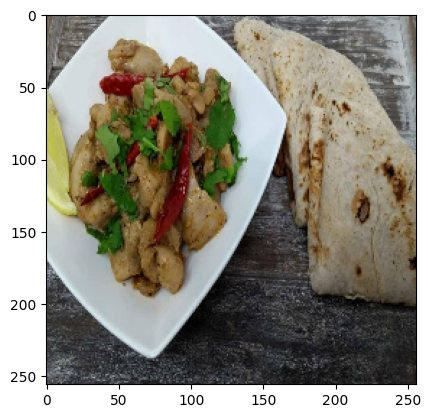

In [42]:
#Prediction on a sample image
import numpy as np
for images_batch,label_batch in test_ds.take(1):
    first_image=images_batch[0].numpy().astype('uint8')
    first_label=label_batch[0]
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",classnames[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",classnames[np.argmax(batch_prediction[0])])

In [43]:
import os
model_version=max([int(i) for i in os.listdir("./Model2") + [0]])+1
model.save(f"./Model2/{model_version}")

INFO:tensorflow:Assets written to: ./Model2/1\assets


INFO:tensorflow:Assets written to: ./Model2/1\assets
